In [1]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os

In [2]:
import json
import random

# Prepare for annotation

### Sample PMIDs

In [18]:
file_path = "./pubmed/cns_psychiatric_diseases_mesh.txt"

df_pmids = pd.read_csv(file_path, header=None)
df_pmids.columns = ['PMID']
df_pmids.shape

(2788345, 1)

In [ ]:
df_pmids.head()

,PMID
0,4
1,7
2,110
3,126
4,152


In [12]:
# Set a fixed seed for reproducibility
seed_value = 42
# Use the sample method to obtain a random sample of 5000 rows
df_sample = df_pmids.sample(n=5000, random_state=seed_value)

In [14]:
df_sample.head()

,PMID
2475761,32576286
577415,7442988
1170420,15115064
1887165,24517058
2685241,35894918


In [19]:
# Save the sampled DataFrame as a tab-separated text file
output_file_path = "./pubmed/cns_psychiatric_diseases_mesh_5000_sample_pmids.txt"
df_sample.to_csv(output_file_path, index=False)

In [32]:
# NOTE: based on those IDs the contents will be fetched via the PubMed API, see README for details

### Read PubMed EDirect Outputs

In [20]:
file_path = "./pubmed/pmid_contents_mesh_query.txt"

df = pd.read_csv(file_path, sep='^')
df.columns = ['PMID', 'PubDate/Year', 'Journal/Title', 'ArticleTitle', 'AbstractText', 'doi']

In [21]:
df.shape

(4999, 6)

In [22]:
df.head()

,PMID,PubDate/Year,Journal/Title,ArticleTitle,AbstractText,doi
0,18753,1977.0,Psychopharmacology bulletin,An uncontrolled clinical study with piperaceta...,NaN,NaN
1,26201,1978.0,Acta virologica,Transmissible virus dementia. II. Neurohistolo...,Histopathological findings in three temporo-sp...,NaN
2,50412,1975.0,Journal of neurology,Iophendylate cisternography in diagnosis of ce...,60 cases of bilateral cerebellopontine angle p...,10.1007/BF00312802
3,61390,1976.0,"Lancet (London, England)",Cardiopulmonary resuscitation by lay people.,The survival-rate in 75 of 631 patients with c...,10.1016/s0140-6736(76)90002-7
4,63356,1976.0,Child psychiatry and human development,Negotiating educational programs for children ...,An approach to negotiating educational program...,10.1007/BF01464418


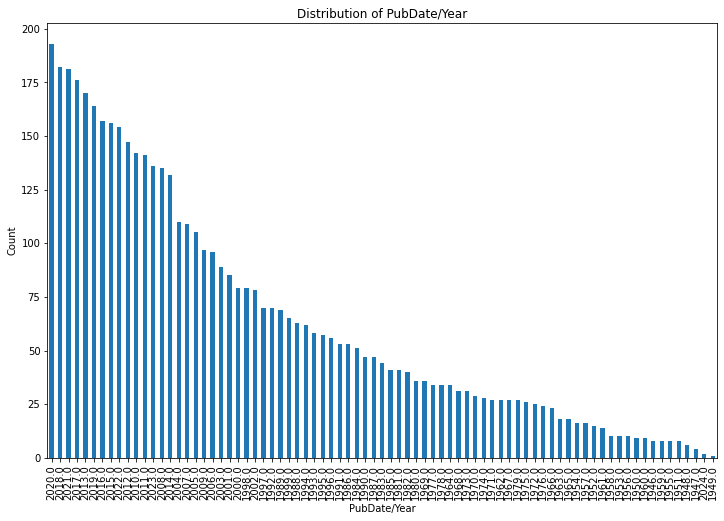

In [24]:
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(12, 8))

# Assuming df is your DataFrame
# Plot the distribution of values in PubDate/Year
df['PubDate/Year'].value_counts().plot(kind='bar')

plt.xlabel('PubDate/Year')
plt.ylabel('Count')
plt.title('Distribution of PubDate/Year')

# Display the plot
plt.show()


In [25]:
df_cleaned = df.dropna(subset=['AbstractText'])

In [26]:
df_cleaned.shape

(3560, 6)

In [27]:
# Fill NaN values with an empty string
df_cleaned = df_cleaned.fillna('')
df_cleaned['AbstractText'] = df_cleaned['AbstractText'].str.replace('"', "\'")
df_cleaned['ArticleTitle'] = df_cleaned['ArticleTitle'].str.replace('"', "\'")

# Concatenate the desired columns with ^ separator
df_cleaned['text'] = df_cleaned[['Journal/Title', 'ArticleTitle', 'AbstractText']].apply(lambda x: '^\\n'.join(map(str, x)), axis=1)

# Create a new DataFrame with only the required columns
result_df = df_cleaned[['PMID', 'text']]
result_df.to_csv("./prodigy/input/all_{}_pubmed_with_abstracts.csv".format(len(result_df)))

### Prepare in JSONL format for Prodigy

In [28]:
# Set a seed for reproducibility
np.random.seed(42)

# Randomly sample 2000 rows
sampled_df = result_df.sample(n=2000)

# Split into two DataFrames
pilot_df = sampled_df.head(500)
postpilot_df = sampled_df.tail(1500)

# Convert the DataFrames to JSONL format
pilot_jsonl_data = pilot_df.to_dict(orient='records')
postpilot_jsonl_data = postpilot_df.to_dict(orient='records')

# Save the sampled data to JSONL files
with open('./prodigy/input/pilot_500_pubmed_abstracts.jsonl', 'w') as pilot_file:
    for line in pilot_jsonl_data:
        pilot_file.write(f'{{"pmid": "{line["PMID"]}", "text": "{line["text"]}"}}\n')

with open('./prodigy/input/postpilot_1500_pubmed_abstracts.jsonl', 'w') as postpilot_file:
    for line in postpilot_jsonl_data:
        postpilot_file.write(f'{{"pmid": "{line["PMID"]}", "text": "{line["text"]}"}}\n')


In [29]:
# Convert the DataFrame to JSONL format
jsonl_data = result_df.to_dict(orient='records')

# Save the JSONL data to a file
with open('./prodigy/pubmed_abstracts.jsonl', 'w') as jsonl_file:
    for line in jsonl_data:
        jsonl_file.write(f'{{"pmid": "{line["PMID"]}", "text": "{line["text"]}"}}\n')

In [30]:
result_df

,PMID,text
1,26201,Acta virologica^\nTransmissible virus dementia...
2,50412,Journal of neurology^\nIophendylate cisternogr...
3,61390,"Lancet (London, England)^\nCardiopulmonary res..."
4,63356,Child psychiatry and human development^\nNegot...
8,78395,"Lancet (London, England)^\nHaemophilus meningi..."
...,...,...
4994,37860852,European journal of psychotraumatology^\nTreat...
4995,37900065,Journal of medicine and life^\nA retrospective...
4996,37905374,Cognitive science^\nRepeat After Me? Both Chil...
4997,37951702,Neuroimaging clinics of North America^\nTreatm...


## Second Pilot

In [4]:
input_file_path = './prodigy/input/postpilot_1500_pubmed_abstracts.jsonl'
sampled_file_path = './prodigy/input/pilot_2_sampled_200.jsonl'
remaining_file_path = './prodigy/input/remaining_1300.jsonl'

# Read the JSONL file
with open(input_file_path, 'r') as file:
    lines = file.readlines()

# Randomly sample 200 lines
sampled_lines = random.sample(lines, 200)

# Save the sampled lines to one file
with open(sampled_file_path, 'w') as sampled_file:
    sampled_file.writelines(sampled_lines)

# Save the remaining lines to another file
remaining_lines = [line for line in lines if line not in sampled_lines]
with open(remaining_file_path, 'w') as remaining_file:
    remaining_file.writelines(remaining_lines)

## Set prodigy ids

In [1]:
import json

# Read the JSONL file
with open("./prodigy/annotated_output/pilot_500_pubmed_abstracts_shirin.jsonl", 'r') as file:
    lines = file.readlines()

# Process each line
for i, line in enumerate(lines):
    data = json.loads(line)

    # Replace values
    data['_session_id'] = 'pilot-500-shirin'
    data['_annotator_id'] = 'shirin'

    # Convert back to JSON string
    lines[i] = json.dumps(data) + '\n'

# Write the modified data back to the file
with open('./prodigy/annotated_output/pilot_500_pubmed_abstracts_shirin_correct_id.jsonl', 'w') as file:
    file.writelines(lines)

# Read and combine annotated data

In [3]:
def visualize_label_frequencies(df, annotator_name, save_path='./prodigy/viz'):
    # Mapping labels to numerical values
    labels = ["Human-systematic-review", "Human-RCT-drug-intervention", "Human-RCT-non-drug-intervention", "Human-RCT-non-intervention", "Human-case-report", "Human-non-RCT-drug-intervention", "Human-non-RCT-non-drug-intervention", "Animal-systematic-review", "Animal-drug-intervention", "Animal-non-drug-intervention", "Animal-other", "Non-systematic-review", "In-vitro-study", "Clinical-study-protocol", "Remaining"]

    label_to_numerical = {label: i for i, label in enumerate(labels)}

    # Create a new column with mapped values
    label_title = 'accepted_label'

    # Plotting the frequency of each label with inverted y-axis and values on bars
    plt.figure(figsize=(10, 6))
    ax = df[label_title].value_counts().sort_values(ascending=True).plot(kind='barh', color='skyblue')
    plt.title(f'Label Frequency')
    plt.xlabel('Frequency')
    plt.ylabel('Label')

    # Display the frequency values on the bars
    for i, value in enumerate(df[label_title].value_counts().sort_values(ascending=True)):
        ax.text(value, i, str(value), va='center', ha='left')

    # Ensure the 'viz' folder exists
    os.makedirs(save_path, exist_ok=True)

    # Save the plot as an image
    save_filename = os.path.join(save_path, f'label_frequency_{annotator_name}_{len(df)}.png')
    plt.savefig(save_filename, bbox_inches='tight')
    plt.show()

In [4]:
def read_and_process_jsonl_to_df(file_path):
    data_list = []

    # Read the JSONL file line by line
    with open(file_path, 'r') as file:
        for line in file:
            # Parse each line as a JSON object
            data = json.loads(line.strip())

            # Check if _view_id is "review"
            if data.get("_view_id") == "review":
                answer = data.get("answer")
                if answer != "accept":
                    print(answer)
                    if answer == "reject":
                        continue
                # Split text into journal_name, title, and abstract based on ^\n symbol
                text = data.get("text", "")
                parts = text.split("^\n", 2)  # Split into three parts based on first two ^\n occurrences
                
                journal_name = parts[0].strip() if len(parts) > 0 else ""
                title = parts[1].strip() if len(parts) > 1 else ""
                abstract = parts[2].strip() if len(parts) > 2 else ""
                
                # Extract other required fields
                pmid = data.get("pmid", "")
                accept = data.get("accept", [])
                
                # Append to the list
                data_list.append({
                    "pmid": pmid,
                    "journal_name": journal_name,
                    "title": title,
                    "abstract": abstract,
                    "accepted_label": accept
                })
            else:
                print("review id was: ", data.get("_view_id"))

    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(data_list)
    return df

In [5]:
file_name_1 = './prodigy/annotated_output/final/1300_remaining_abstracts_merged.jsonl'
result_df_1 = read_and_process_jsonl_to_df(file_name_1)
result_df_1.shape

(1299, 5)

In [6]:
result_df_1.head()

,pmid,journal_name,title,abstract,accepted_label
0,18379746,Der Radiologe,[Pediatric stroke].,Stroke in childhood has gained increasingly mo...,[Non-systematic-review]
1,24660674,Journal of consulting and clinical psychology,Treatment engagement and response to CBT among...,"In the current study, we compared measures of ...",[Human-RCT-non-drug-intervention]
2,20159133,Archives of physical medicine and rehabilitation,Relationship between perceived exertion and ph...,To investigate the strength of the relationshi...,[Remaining]
3,11781147,Biochimica et biophysica acta,Characterization of a missense mutation at his...,Genetic defects in pyruvate dehydrogenase comp...,[Remaining]
4,31706919,Epilepsy & behavior : E&B,The role of P-glycoprotein (P-gp) and inwardly...,Sudden unexpected death in epilepsy (SUDEP) is...,[Non-systematic-review]


In [7]:
file_name_2 = './prodigy/annotated_output/final/pilot1_re-annotated_merged.jsonl'
result_df_2 = read_and_process_jsonl_to_df(file_name_2)
result_df_2.shape

reject
reject
reject


(497, 5)

In [8]:
result_df_2.head()

,pmid,journal_name,title,abstract,accepted_label
0,37550718,Trials,Can dexamethasone improve postoperative sleep ...,Perioperative sleep disorders (PSD) are an ind...,[Human-RCT-drug-intervention]
1,2500373,Developmental medicine and child neurology,Effects of puberty on seizure frequency.,"Seizure frequency was documented before, durin...",[Remaining]
2,36189588,Journal of Alzheimer's disease : JAD,Characterization of Mild Cognitive Impairment ...,"Despite tremendous advancements in the field, ...",[Remaining]
3,36314672,Journal of vector ecology : journal of the Soc...,Effects of woody plant encroachment by eastern...,Woody plant encroachment into grasslands is oc...,[Remaining]
4,29172241,Depression and anxiety,The impact of resilience and subsequent stress...,There remains a dearth of research examining t...,[Remaining]


In [9]:
file_name_3 = './prodigy/annotated_output/final/pilot_2_reviewed_merged.jsonl'
result_df_3 = read_and_process_jsonl_to_df(file_name_3)
result_df_3.shape

(200, 5)

In [10]:
result_df_3.head()

,pmid,journal_name,title,abstract,accepted_label
0,2420691,Fortschritte der Neurologie-Psychiatrie,[Aphasia in children].,The acquired aphasia in children is a rarely s...,[Non-systematic-review]
1,23027099,Journal of clinical neurophysiology : official...,Epileptic encephalopathies in infants and chil...,The term epileptic encephalopathy is used to d...,[Non-systematic-review]
2,17018553,Journal of pediatric psychology,Family socialization of adolescent's self-repo...,To examine the main and interactive effects of...,[Remaining]
3,27935389,"Journal of mental health (Abingdon, England)",The effect of Interaction Anxiousness Scale an...,Social anxiety disorder (SAD) is one of the mo...,[Remaining]
4,29101712,Journal of cancer survivorship : research and ...,Posttraumatic stress-related psychological fun...,The majority of research examining posttraumat...,[Non-systematic-review]


In [11]:
df_concatenated = pd.concat([result_df_1, result_df_2, result_df_3], ignore_index=True)
df_concatenated = df_concatenated.explode('accepted_label')
df_concatenated.shape

(1996, 5)

In [12]:
len(set(df_concatenated['pmid']))

1996

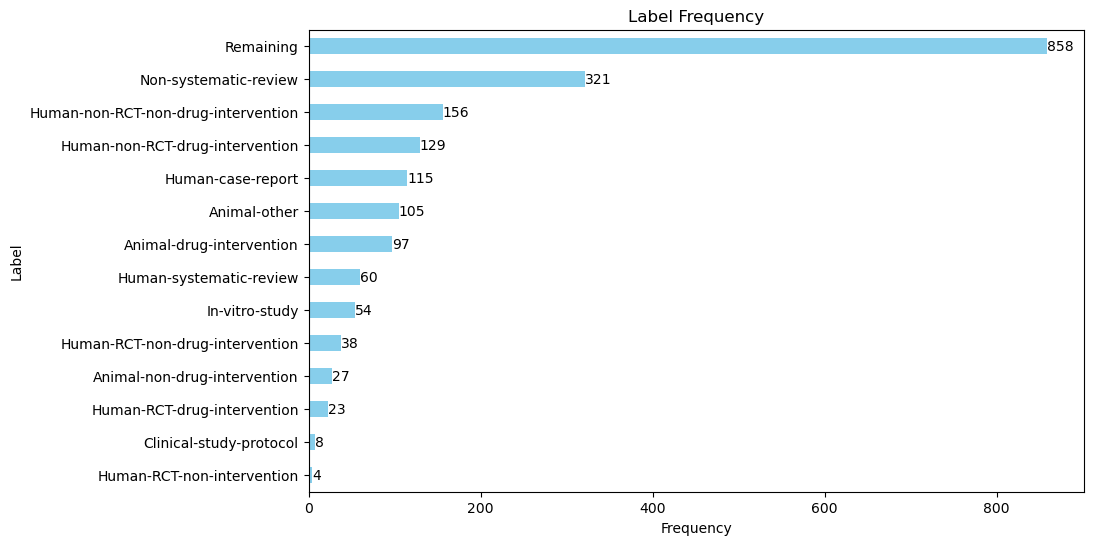

In [13]:
visualize_label_frequencies(df_concatenated, 'final_merged', save_path='./prodigy/viz')

In [14]:
df_concatenated.head()

,pmid,journal_name,title,abstract,accepted_label
0,18379746,Der Radiologe,[Pediatric stroke].,Stroke in childhood has gained increasingly mo...,Non-systematic-review
1,24660674,Journal of consulting and clinical psychology,Treatment engagement and response to CBT among...,"In the current study, we compared measures of ...",Human-RCT-non-drug-intervention
2,20159133,Archives of physical medicine and rehabilitation,Relationship between perceived exertion and ph...,To investigate the strength of the relationshi...,Remaining
3,11781147,Biochimica et biophysica acta,Characterization of a missense mutation at his...,Genetic defects in pyruvate dehydrogenase comp...,Remaining
4,31706919,Epilepsy & behavior : E&B,The role of P-glycoprotein (P-gp) and inwardly...,Sudden unexpected death in epilepsy (SUDEP) is...,Non-systematic-review


In [15]:
df_concatenated.to_csv("./prodigy/annotated_output/final/full_combined_dataset_{}.csv".format(len(df_concatenated)))

In [17]:
df_concatenated.shape

(1996, 5)

In [16]:
# Path to save the JSONL file
file_path = './prodigy/annotated_output/final/full_combined_dataset_{}.jsonl'.format(len(df_concatenated))

# Convert DataFrame to JSONL and save
with open(file_path, 'w') as file:
    for _, row in df_concatenated.iterrows():
        json.dump(row.to_dict(), file)
        file.write('\n')